In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_13412/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [3]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [4]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [5]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.5490, 0.4863, 0.4353,  ..., 0.0000, 0.1020, 0.2157],
         [0.6392, 0.6392, 0.5804,  ..., 0.0000, 0.0000, 0.1843],
         [0.5843, 0.6392, 0.6431,  ..., 0.0000, 0.0039, 0.0784],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1490, 0.1647],
         [0.0510, 0.0980, 0.0706,  ..., 0.0510, 0.1412, 0.1647],
         [0.5843, 0.5922, 0.5529,  ..., 0.0275, 0.0275, 0.0000]],

        [[0.5804, 0.5255, 0.4941,  ..., 0.0000, 0.0863, 0.2549],
         [0.6588, 0.6745, 0.6275,  ..., 0.0000, 0.0000, 0.2078],
         [0.6235, 0.6706, 0.6471,  ..., 0.0000, 0.0000, 0.0392],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1294, 0.1412],
         [0.0510, 0.0980, 0.0941,  ..., 0.0510, 0.1098, 0.1333],
         [0.5961, 0.5961, 0.5569,  ..., 0.0118, 0.0196, 0.0000]],

        [[0.5490, 0.4863, 0.4353,  ..., 0.0000, 0.0353, 0.1451],
         [0.6314, 0.6392, 0.5725,  ..., 0.0000, 0.0000, 0.1020],
         [0.5529, 0.6118, 0.5961,  ..., 

In [6]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


In [7]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [8]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [10]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Build binary classifier on latents

In [11]:
from torch.autograd import Variable

## Helper functions:

In [12]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [13]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [14]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [15]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [16]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [17]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader
def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [18]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

## Load the data

In [19]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [20]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [21]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [22]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [23]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [24]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)
print(test_latents.shape)

(55, 7, 128)


In [25]:
data_hold, label_hold = gen_binary_data(latents, meta)
print(data_hold.shape)

(7350, 256)


In [26]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [27]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape[0])

2695


In [28]:
def compare_means(train_data, test_data):
    # Calculate the mean of each feature for both datasets
    train_means = train_data.mean(axis=0)
    test_means = test_data.mean(axis=0)

    # Calculate the difference in means between the two datasets
    mean_differences = test_means - train_means

    # Output the results
    for i in range(len(train_means)):
        print(f"Feature {i+1}: Train Mean = {train_means[i]:.3f}, Test Mean = {test_means[i]:.3f}, Difference = {mean_differences[i]:.3f}")
compare_means(data_hold, test_hold)

Feature 1: Train Mean = 0.025, Test Mean = -0.038, Difference = -0.063
Feature 2: Train Mean = 0.060, Test Mean = -0.023, Difference = -0.083
Feature 3: Train Mean = -0.168, Test Mean = -0.149, Difference = 0.018
Feature 4: Train Mean = 0.010, Test Mean = 0.022, Difference = 0.012
Feature 5: Train Mean = 0.023, Test Mean = 0.042, Difference = 0.018
Feature 6: Train Mean = -0.051, Test Mean = -0.033, Difference = 0.018
Feature 7: Train Mean = -0.510, Test Mean = -0.397, Difference = 0.113
Feature 8: Train Mean = 0.021, Test Mean = -0.053, Difference = -0.075
Feature 9: Train Mean = 0.192, Test Mean = 0.067, Difference = -0.124
Feature 10: Train Mean = -0.147, Test Mean = -0.153, Difference = -0.006
Feature 11: Train Mean = 0.022, Test Mean = 0.187, Difference = 0.165
Feature 12: Train Mean = 0.329, Test Mean = 0.244, Difference = -0.085
Feature 13: Train Mean = 0.002, Test Mean = -0.009, Difference = -0.011
Feature 14: Train Mean = 0.159, Test Mean = -0.014, Difference = -0.174
Feature 

In [29]:
print(test_hold)

[[ 0.47049916  0.6883099  -0.461613   ... -0.4230149  -0.45559126
   0.32823116]
 [ 0.47049916  0.6883099  -0.461613   ...  0.24641067 -0.17720075
  -0.08096878]
 [ 0.47049916  0.6883099  -0.461613   ... -0.3952378  -0.29297495
   0.2974927 ]
 ...
 [-0.03606359  0.07955236 -0.1024786  ...  0.09751336  0.09942641
  -0.14153942]
 [-0.03606359  0.07955236 -0.1024786  ...  0.06232986 -0.00080989
  -0.20980963]
 [-0.03606359  0.07955236 -0.1024786  ...  0.00486828  0.01946105
  -0.14402598]]


### Create Balanced dataset from the test dataset

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
data_resampled, label_resampled = smote.fit_resample(test_hold, test_label)

## Load the model

In [31]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function    
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



# Models' Robustness

## Robustness with Data Interpolation

## Iteration through model runs, same noise

### Accuracy for original imbalanced data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']
{'sdr_kfold_shap_10_aplha03_25_1000_l1': [0.8852690166975881, 0.8834879406307978, 0.878886827458256, 0.8685714285714285, 0.8477179962894248, 0.8179591836734694, 0.7720964749536179, 0.7184415584415584, 0.6690909090909092, 0.6325046382189239], 'sir_intensity_total_shap_10_aplha03': [0.887643784786642, 0.8871985157699444, 0.8825231910946197, 0.8722820037105752, 0.8529128014842302, 0.8190352504638219, 0.7707977736549165, 0.7120222634508349, 0.6616697588126159, 0.6249721706864565], 'binary_classifier_sota_10': [0.8940259740259741, 0.8931725417439704, 0.8880148423005567, 0.8751391465677181, 0.8572541743970316, 0.8267903525046382, 0.7839332096474954, 0.7357328385899815, 0.6857513914656771, 0.6480890538033395], 'sdr_average_10_aplha03_1000_l1': [0.8899814471243042, 0.8883858998144711, 0.8830426716141002, 0.8733951762523191, 0.8542857142857143, 0.8212987

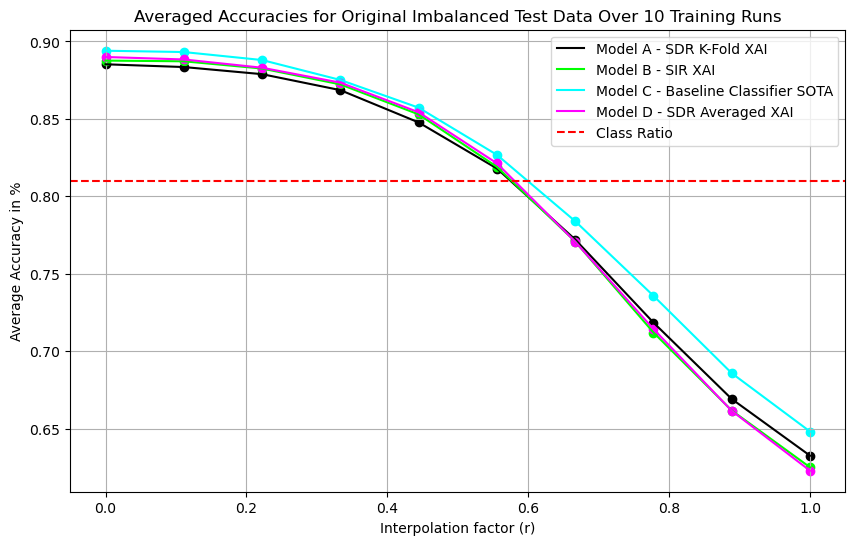

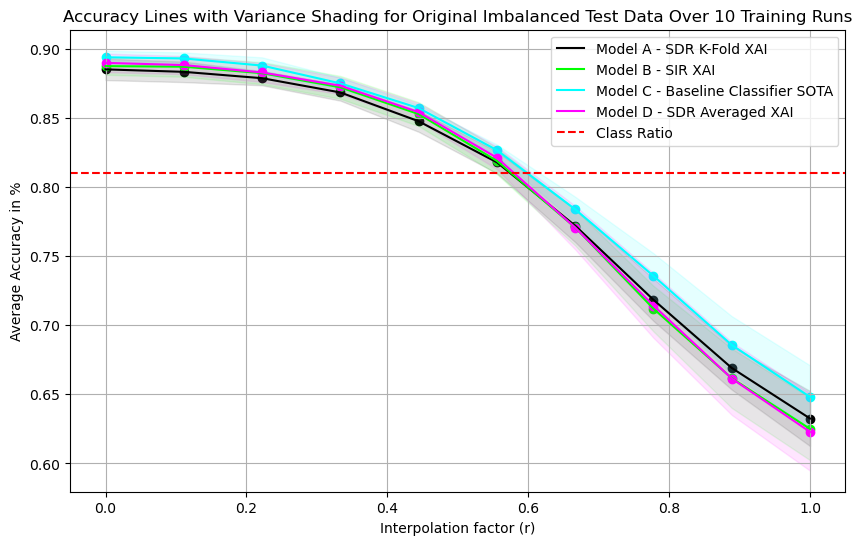

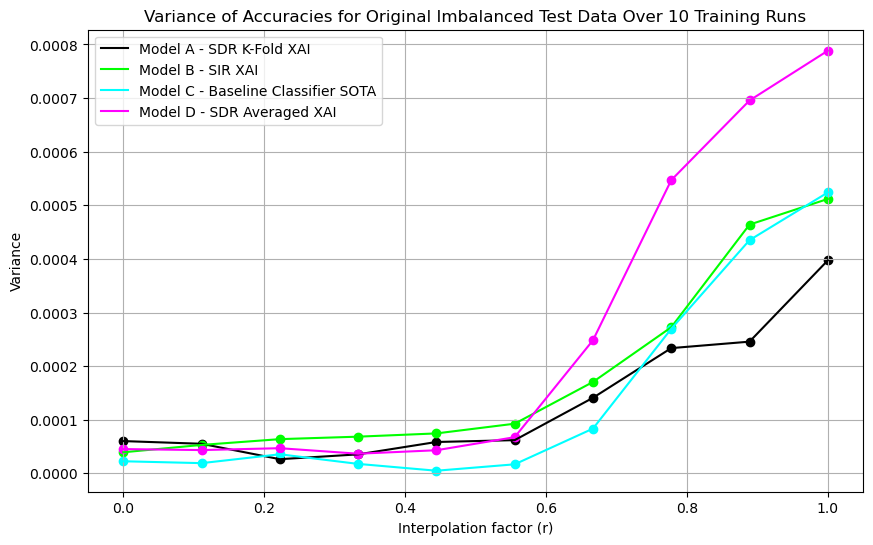

In [34]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def interpolate_with_given_noise(data, r):
   

    # Interpolate the original data with the generated noise
    interpolated_data = (1 - r) * data + r * noise

    return interpolated_data
 
    
# evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

# generate noise once
# calculate the mean and standard deviation for each feature in the test
data_means = test_hold.mean(axis=0)
data_stds = test_hold.std(axis=0)

# generate Gaussian noise with the mean and standard deviation of the test data
noise = np.random.normal(data_means, data_stds, size=test_hold.shape)

for r in r_values:
    
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # list all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)

            accuracy = evaluate_model_on_interpolated_data(test_hold, test_label, model, device, r, noise)
            accuracies.append(accuracy)

        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))
print(results)

# add majority class ratio     
majority_class_ratio = max(np.mean(test_label), 1 - np.mean(test_label))

# model names dictionary
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

# color dictionary for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  

# Plot 1: just the accuracy lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)  # Use .get() for safe access
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: accuracy lines for each model with the variance shown as the filled space
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name) 
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")

plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: just the variance lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name) 
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values

# save results to a CSV file
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_imbalanced.csv'), index=False)

# convert variances to a DataFrame
df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values

# save variances to a CSV file
df_variances.to_csv(os.path.join(base_dir, 'variances_imbalanced.csv'),
                     index=False)



### Accuracy for class balanced test data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']


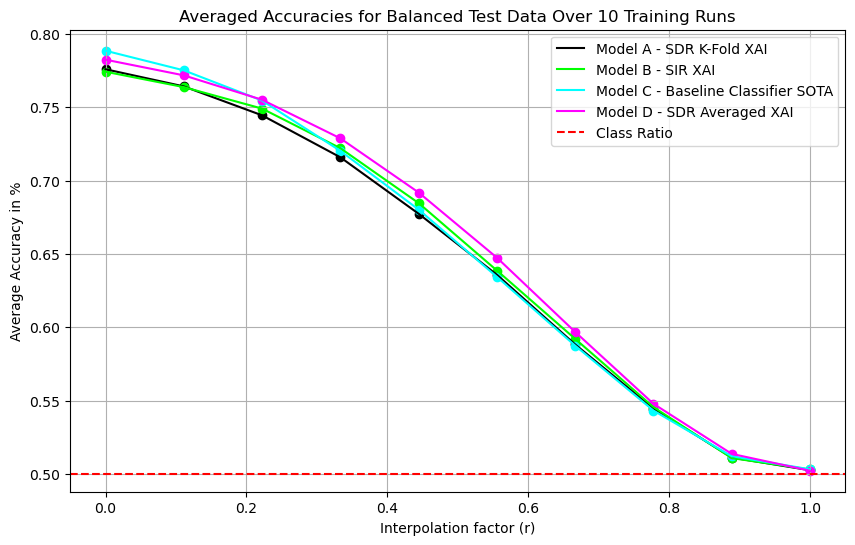

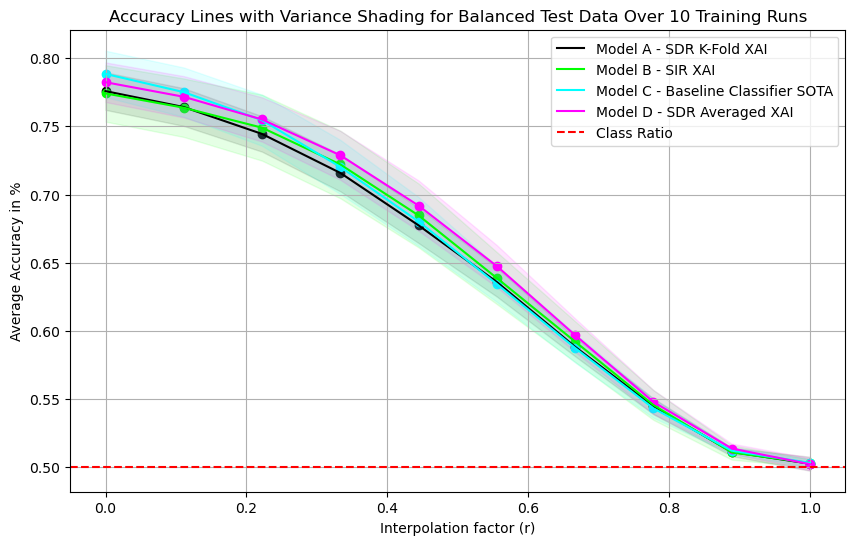

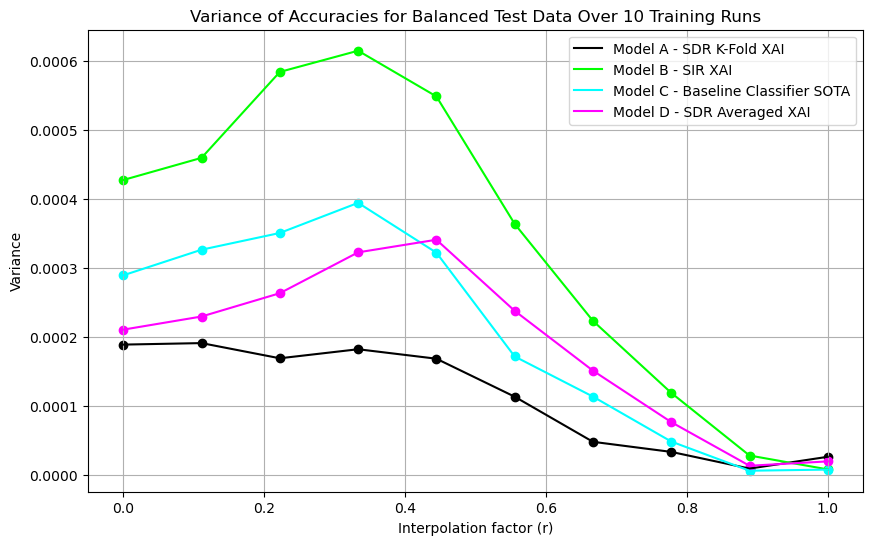

In [35]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def interpolate_with_given_noise(data, r):
    # Interpolate the original data with the generated noise
    interpolated_data = (1 - r) * data + r * noise
    return interpolated_data
 

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders, insert needed folder
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

# noise once
 # calculate the mean and standard deviation for each feature in the test
data_means = data_resampled.mean(axis=0)
data_stds = data_resampled.std(axis=0)

# generate Gaussian noise with the mean and standard deviation of the test data
noise = np.random.normal(data_means, data_stds, size=data_resampled.shape)


for r in r_values:
   
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            # data type
            accuracy = evaluate_model_on_interpolated_data(data_resampled, label_resampled, model, device, r, noise)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value in the results
        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))

# add class ratio     
majority_class_ratio = max(np.mean(label_resampled), 1 - np.mean(label_resampled))
# Corrected model names mapping
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}


# Color mapping for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}


# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  

# Plot 1: Just the accuracy lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Accuracy lines for each model with the variance shown as the filled space and scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Just the variance lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)  # Add scatter points
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Save results and variances to CSV files
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_balanced.csv'), index=False)

df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values
df_variances.to_csv(os.path.join(base_dir, 'variances_balanced.csv'), index=False)

# Robustness of an Explanation

### Average Sensitivity for 1000 random samples up to 5% perturbations, every model gets the same random noise and the same random subset for every r

# MSE

## same subset =  1000 for all levels


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


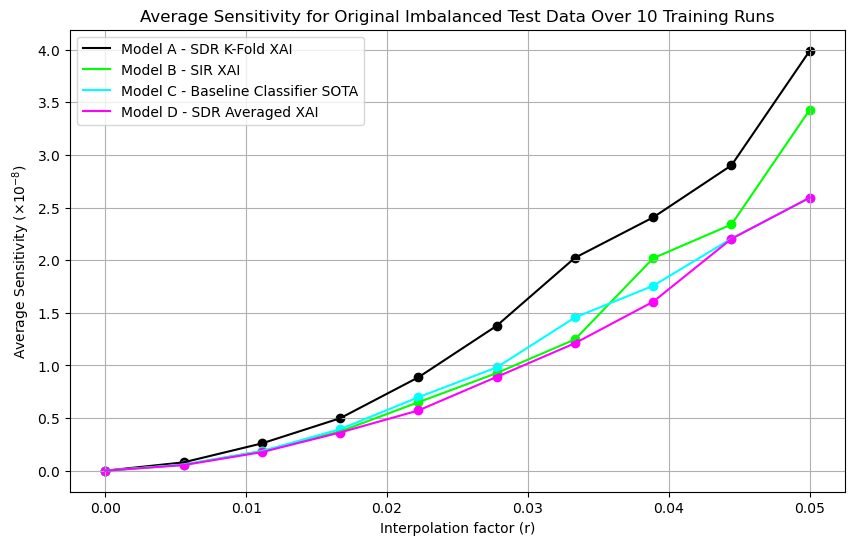

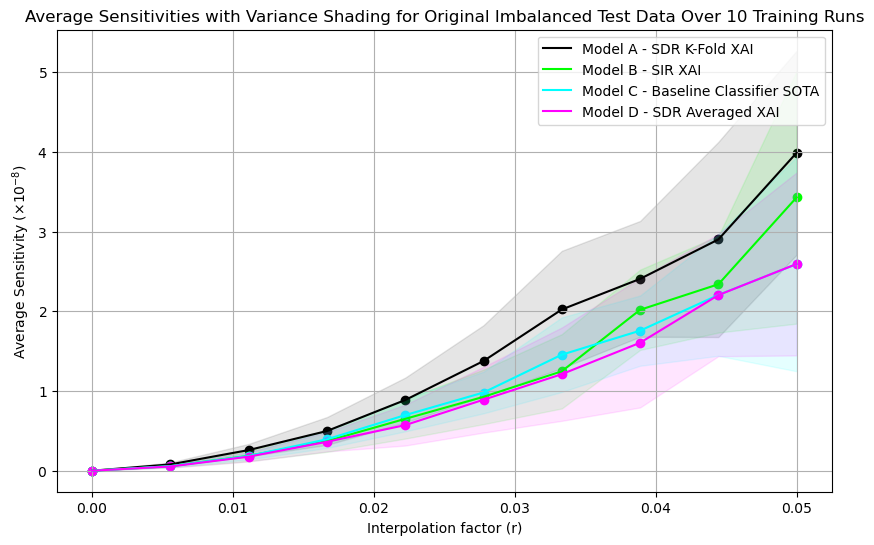

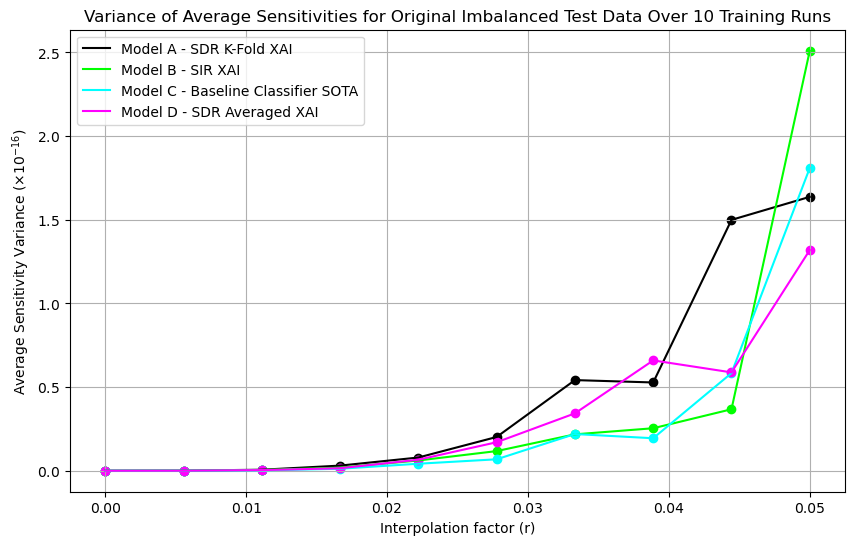

In [86]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter



def interpolate_with_given_noise(data, r, noise):
    noise = noise[:len(data)]
    # Interpolate the original data with the generated noise
    interpolated_data = (1 - r) * data + r * noise

    return interpolated_data
 


# create a SHAP explainer for the given model and background data
def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer


# maybe we need to generate indices out of this function compute shap values ones for them and that is it
def compute_average_sensitivity(model, indices, r, noise, num_samples=1000, background_size=1000):

    # Generate background data
    random_indices = np.random.choice(len(test_hold), size=background_size, replace=False)
    background_data = test_hold[random_indices]
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)

    # set explainer
    explainer = create_explainer(model, background_data_tensor)

    mse_differences = []
    detailed_data = []  # Collecting detailed information

    for i in range(min(num_samples, len(indices))):
        actual_data_sample = test_hold[indices[i]]
        data_tensor = torch.tensor(actual_data_sample, dtype=torch.float32).unsqueeze(0).to(device)
        

        # Predictions for original data
        preds_original = model(data_tensor).detach().cpu().numpy()
        
        # Interpolate with noise
        perturbed_data = interpolate_with_given_noise(data_subset[i:i+1], r, noise)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # Predictions for perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        if np.allclose(preds_original, preds_perturbed, atol=1e-5):
            # SHAP values for original data
            shap_values_original = explainer.shap_values(data_tensor)
            shap_values_original = np.array(shap_values_original)
            # Calculate SHAP values for perturbed data
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)

            # Calculate MSE difference for SHAP values
            mse_shap = np.mean((shap_values_original - shap_values_perturbed) ** 2)
            mse_differences.append(mse_shap)

            # Calculate MSE difference for predictions
            mse_pred = np.mean((preds_original - preds_perturbed) ** 2)

            # Append detailed data
            detailed_data.append({
                'model_type': model.__class__.__name__,
                'model_run': model_path,  # Ensure model_path is defined in your main loop
                'noise_level': r,
                'index': indices[i],
                'original_prediction': preds_original.tolist(),  # Convert to list if it's a numpy array
                'perturbed_prediction': preds_perturbed.tolist(),  # Convert to list
                'mse_shap': mse_shap,
                'mse_pred': mse_pred
            })

    return np.mean(mse_differences), detailed_data



base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


# noise range
perturb_radii = np.linspace(0, 0.05, 10)
average_sensitivities = {}
average_sensitivities_var = {}
all_detailed_data = []  # To collect detailed data from all iterations
sensitivity_results = []

# generate noise once for this r-value, so every model gets the same noise
# generate Gaussian noise with the mean and standard deviation of the test data
data_means = test_hold.mean(axis=0)
data_stds = test_hold.std(axis=0)

noise = np.random.normal(data_means, data_stds, size=test_hold.shape)
# select the same subset of data for analysis
indices = np.random.choice(len(test_hold), size=1000, replace=False)
data_subset = test_hold[indices]

data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)
for r in perturb_radii:
    
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)
            
            # compute average sensitivity and collect detailed data NOT RIGHT FOR EVERY RUN ANOTHER SET 
            avg_sensitivity, detailed_data = compute_average_sensitivity(model, indices, r, noise)
            sensitivity_list.append(avg_sensitivity)
            
            
            # the detailed data
            for data_point in detailed_data:
                data_point.update({
                    'model_type': folder,
                    'model_run': run,
                    'perturb_radius': r
                })
            
            # collect detailed data from this run
            all_detailed_data.extend(detailed_data)
            sensitivity_results.append({'model': folder, 'run': run, 'sensitivity': avg_sensitivity, 'perturb_radius': r})

        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list)) # divide by number of models?
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))
       
# save the average sensitivities and their variance as before
df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_1000_mse_same.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_1000_mse_same.csv'), index=False)

# save detailed data into a CSV file
df_detailed_data = pd.DataFrame(all_detailed_data)
df_detailed_data.to_csv(os.path.join(base_dir, 'detailed_sensitivity_data_mse_same.csv'), index=False)

df_sensitivity_results = pd.DataFrame(sensitivity_results)
df_sensitivity_results.to_csv(os.path.join(base_dir, 'sensitivity_results_1000_mse_same.csv'), index=False)

# the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # 'gray' if model not found



def format_ylabel(ax, label):
    # use the ticklabel_format to force scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    
    # get the offset text, which is the scientific notation exponent
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax

# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # filter out None or NaN values and their corresponding radii 
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color) 
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivity for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # calculate standard deviations while ignoring NaN values
    std_devs = np.sqrt(np.nan_to_num(average_sensitivities_var[model_file_name]))
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    valid_std_devs = std_devs[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)  # add dots
    # to ensure the shaded area is always above 0, we use np.maximum
    plt.fill_between(valid_radii,
                 np.maximum(valid_sensitivities - valid_std_devs, 0),
                 valid_sensitivities + valid_std_devs,
                 color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # ignore NaN values for plotting
    valid_indices = ~np.isnan(sensitivity_values_var)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities_var = np.array(sensitivity_values_var)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities_var, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities_var, color=color)  
format_ylabel(ax3, "Average Sensitivity Variance")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Variance of Average Sensitivities for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()



In [119]:
file_path = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/detailed_sensitivity_data_mse_same.csv'
data = pd.read_csv(file_path)

# count the number of rows for each model type
row_counts = data['model_type'].value_counts()


print(row_counts)


sir_intensity_total_shap_10_aplha03     33024
sdr_kfold_shap_10_aplha03_25_1000_l1    32760
sdr_average_10_aplha03_1000_l1          30410
binary_classifier_sota_10               25588
Name: model_type, dtype: int64


In [118]:

file_path = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/sensitivity_results_1000_mse_same.csv'
data = pd.read_csv(file_path)

# group the data by model type and calculate the mean sensitivity
average_sensitivities = data.groupby('model')['sensitivity'].mean()

# display the overall average sensitivities for each model
print(average_sensitivities)


model
binary_classifier_sota_10               1.032827e-08
sdr_average_10_aplha03_1000_l1          9.671734e-09
sdr_kfold_shap_10_aplha03_25_1000_l1    1.442337e-08
sir_intensity_total_shap_10_aplha03     1.123151e-08
Name: sensitivity, dtype: float64


In [110]:

sensitivities = {
    'binary_classifier_sota_10': 1.032827e-08,
    'sdr_average_10_aplha03_1000_l1': 9.671734e-09,
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 1.442337e-08,
    'sir_intensity_total_shap_10_aplha03': 1.123151e-08
}


case_counts = {
    'binary_classifier_sota_10': 25588,
    'sdr_average_10_aplha03_1000_l1': 30410,
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 32760,
    'sir_intensity_total_shap_10_aplha03': 33024
}


normalized_sensitivities = {model: sens / case_counts[model] for model, sens in sensitivities.items()}

print(normalized_sensitivities)


{'binary_classifier_sota_10': 4.036372518367985e-13, 'sdr_average_10_aplha03_1000_l1': 3.1804452482735943e-13, 'sdr_kfold_shap_10_aplha03_25_1000_l1': 4.4027380952380954e-13, 'sir_intensity_total_shap_10_aplha03': 3.40101441375969e-13}


In [117]:
import pandas as pd

# load the detailed sensitivity data
file_path_sensitivity = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/detailed_sensitivity_data_mse_same.csv'
detailed_sensitivity_data = pd.read_csv(file_path_sensitivity)

# count the number of rows for each model type
row_counts = detailed_sensitivity_data['model_type'].value_counts()

# load the average sensitivity results
file_path_results = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/sensitivity_results_1000_mse_same.csv'
average_sensitivity_results = pd.read_csv(file_path_results)

# group the data by model type and calculate the mean sensitivity
average_sensitivities = average_sensitivity_results.groupby('model')['sensitivity'].mean()

# ensure model order in row_counts matches the order in average_sensitivities
row_counts = row_counts.loc[average_sensitivities.index]

# normalizing sensitivities by case counts
normalized_sensitivities = {model: sens / row_counts[model] for model, sens in average_sensitivities.items()}

# combine data into a single DataFrame for display
combined_metrics = pd.DataFrame({
    'Overall Average Sensitivity': average_sensitivities,
    'Unchanged Predictions': row_counts,
    'Normalized Average Sensitivity': pd.Series(normalized_sensitivities)
})

# display the combined metrics
print(combined_metrics)


                                      Overall Average Sensitivity  \
binary_classifier_sota_10                            1.032827e-08   
sdr_average_10_aplha03_1000_l1                       9.671734e-09   
sdr_kfold_shap_10_aplha03_25_1000_l1                 1.442337e-08   
sir_intensity_total_shap_10_aplha03                  1.123151e-08   

                                      Unchanged Predictions  \
binary_classifier_sota_10                             25588   
sdr_average_10_aplha03_1000_l1                        30410   
sdr_kfold_shap_10_aplha03_25_1000_l1                  32760   
sir_intensity_total_shap_10_aplha03                   33024   

                                      Normalized Average Sensitivity  
binary_classifier_sota_10                               4.036374e-13  
sdr_average_10_aplha03_1000_l1                          3.180445e-13  
sdr_kfold_shap_10_aplha03_25_1000_l1                    4.402737e-13  
sir_intensity_total_shap_10_aplha03                   

moving legend to the left

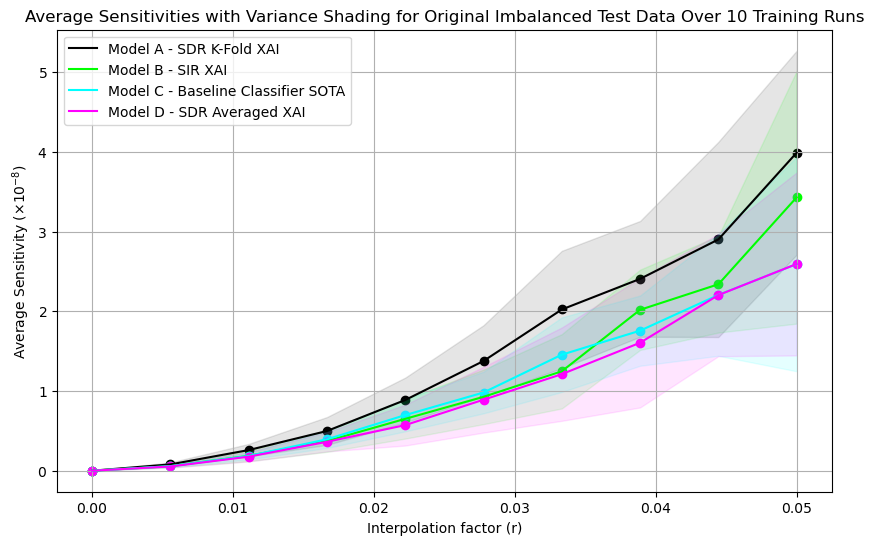

In [89]:
# Model and color mappings
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  

def format_ylabel(ax, label):
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax


avg_sensitivities_df = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/avg_sensitivities_1000_mse_same.csv')
avg_sensitivities_var_df = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/avg_sensitivities_var_1000_mse_same.csv')

perturb_radii = avg_sensitivities_df['perturb_radius']

# reformatting the data
average_sensitivities = {model: avg_sensitivities_df[model].values for model in model_names}
average_sensitivities_var = {model: avg_sensitivities_var_df[model].values for model in model_names}

# Plotting
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(np.nan_to_num(average_sensitivities_var[model_file_name]))
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    valid_std_devs = std_devs[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)
    plt.fill_between(valid_radii, valid_sensitivities - valid_std_devs, valid_sensitivities + valid_std_devs, color=color, alpha=0.1)

format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend(loc='upper left')
plt.grid(True)
plt.title("Average Sensitivities with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

<Figure size 1000x800 with 0 Axes>

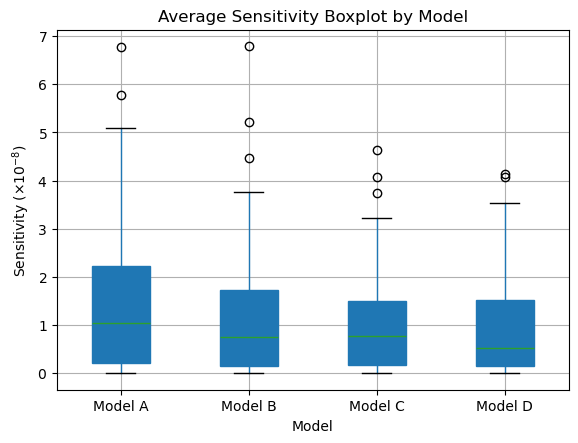

In [113]:
# load the data from CSV file
sensitivity_results = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/sensitivity_results_1000_mse_same.csv')

def format_ylabel(ax, label):
    # Use the ticklabel_format to force scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    
    # get the offset text, which is the scientific notation exponent
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax

# map model names for reaadability
model_name_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A',
    'sir_intensity_total_shap_10_aplha03': 'Model B',
    'binary_classifier_sota_10': 'Model C',
    'sdr_average_10_aplha03_1000_l1': 'Model D'
}
sensitivity_results['model'] = sensitivity_results['model'].map(model_name_mapping)


# create the boxplot and keep references to the artist elements
plt.figure(figsize=(10, 8))
boxplot_artists = sensitivity_results.boxplot(column='sensitivity', by='model', patch_artist=True, showfliers=True, return_type='dict')

ax = plt.gca()
format_ylabel(ax, "Sensitivity")

plt.suptitle('')
plt.title('Average Sensitivity Boxplot by Model')

# labeling the axes
plt.xlabel('Model')


# display the plot
plt.show()


## Extra Not used in the thesis

Balanced dataset Average Sensitivity


mse same subset

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Mean of empty slice.
invalid value encountered in scalar divide


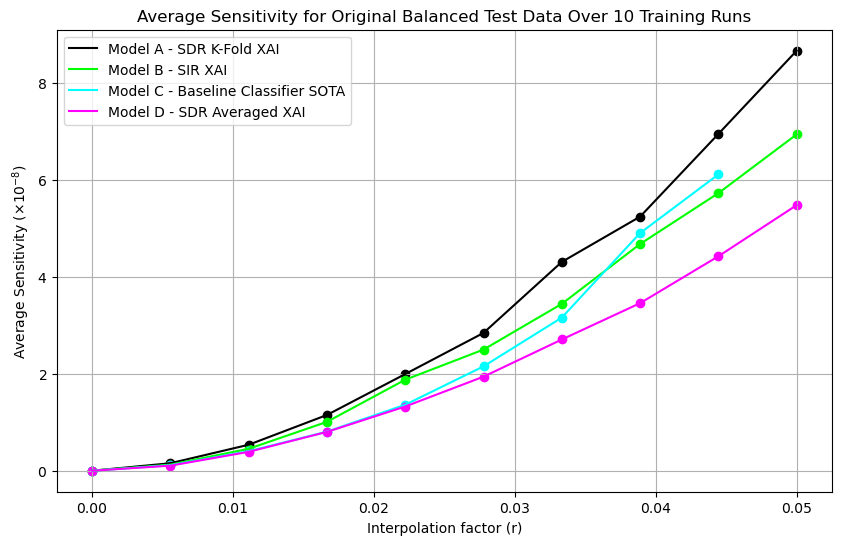

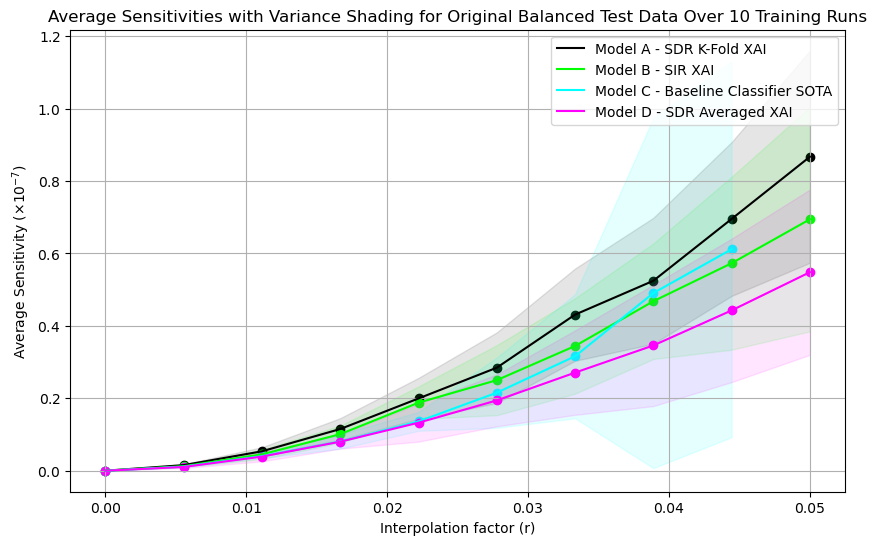

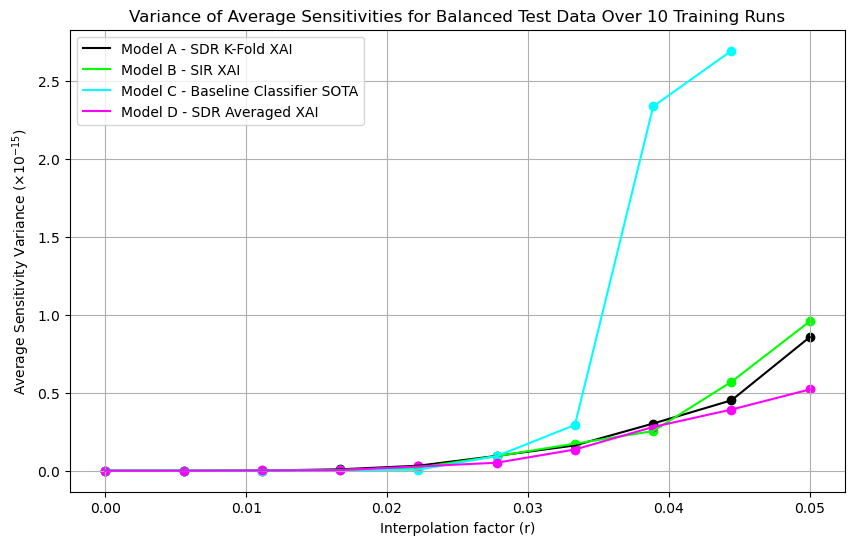

In [92]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter



def interpolate_with_given_noise(data, r, noise):
    noise = noise[:len(data)]
    # Interpolate the original data with the generated noise
    interpolated_data = (1 - r) * data + r * noise

    return interpolated_data
 


# create a SHAP explainer for the given model and background data
def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer


# maybe we need to generate indices out of this fucntion compute shap values ones for them and that is it
def compute_average_sensitivity(model, indices, r, noise, num_samples=1000, background_size=1000):

    # Generate background data
    random_indices = np.random.choice(len(data_resampled), size=background_size, replace=False)
    background_data = data_resampled[random_indices]
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)

    # set explaianer
    explainer = create_explainer(model, background_data_tensor)

    mse_differences = []
    detailed_data = []  # Collecting detailed information

    for i in range(min(num_samples, len(indices))):
        actual_data_sample = data_resampled[indices[i]]
        data_tensor = torch.tensor(actual_data_sample, dtype=torch.float32).unsqueeze(0).to(device)
        

        # Predictions for original data
        preds_original = model(data_tensor).detach().cpu().numpy()
        
        # Interpolate with noise
        perturbed_data = interpolate_with_given_noise(data_subset[i:i+1], r, noise)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # Predictions for perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        if np.allclose(preds_original, preds_perturbed, atol=1e-5):
            # SHAP values for original data
            shap_values_original = explainer.shap_values(data_tensor)
            shap_values_original = np.array(shap_values_original)
            # Calculate SHAP values for perturbed data
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)

            # Calculate MSE difference for SHAP values
            mse_shap = np.mean((shap_values_original - shap_values_perturbed) ** 2)
            mse_differences.append(mse_shap)

            # Calculate MSE difference for predictions
            mse_pred = np.mean((preds_original - preds_perturbed) ** 2)

            # Append detailed data
            detailed_data.append({
                'model_type': model.__class__.__name__,
                'model_run': model_path,  # Ensure model_path is defined in your main loop
                'noise_level': r,
                'index': indices[i],
                'original_prediction': preds_original.tolist(),  # Convert to list if it's a numpy array
                'perturbed_prediction': preds_perturbed.tolist(),  # Convert to list
                'mse_shap': mse_shap,
                'mse_pred': mse_pred
            })

    return np.mean(mse_differences), detailed_data



base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


# adapt as the percentage of test data
perturb_radii = np.linspace(0, 0.05, 10)
average_sensitivities = {}
average_sensitivities_var = {}
all_detailed_data = []  # To collect detailed data from all iterations
sensitivity_results = []


# generate Gaussian noise with the mean and standard deviation of the test data
# Generate noise once for this r-value, so every model gets the same noise
# i think this important because every model is treated the same with the same subset
  
data_means = data_resampled.mean(axis=0)
data_stds = data_resampled.std(axis=0)
noise = np.random.normal(data_means, data_stds, size=data_resampled.shape)
 
# select a subset of data for analysis
indices = np.random.choice(len(data_resampled), size=1000, replace=False)

data_subset = data_resampled[indices]

data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)
   
for r in perturb_radii:
    
    # GET THE SAME SUBSET because not compute average function was calling everytime a new one

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)
            
            # Compute average sensitivity and collect detailed data NOT RIGHT FOR EVERY RUN ANOTHER SET 
            avg_sensitivity, detailed_data = compute_average_sensitivity(model, indices, r, noise)
            sensitivity_list.append(avg_sensitivity)
            
            
            # Add additional details to the detailed data
            for data_point in detailed_data:
                data_point.update({
                    'model_type': folder,
                    'model_run': run,
                    'perturb_radius': r
                })
            
            # Collect detailed data from this run
            all_detailed_data.extend(detailed_data)
            sensitivity_results.append({'model': folder, 'run': run, 'sensitivity': avg_sensitivity, 'perturb_radius': r})

        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list)) # divide by number of models?
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))
       
# Save the average sensitivities and their variance as before
df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_1000_mse_balanced.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_1000_mse_balanced.csv'), index=False)

# Save detailed data into a CSV file
df_detailed_data = pd.DataFrame(all_detailed_data)
df_detailed_data.to_csv(os.path.join(base_dir, 'detailed_sensitivity_data_mse_balanced.csv'), index=False)

# Convert individual sensitivity results to DataFrame and save to CSV
df_sensitivity_results = pd.DataFrame(sensitivity_results)
df_sensitivity_results.to_csv(os.path.join(base_dir, 'sensitivity_results_1000_mse_balanced.csv'), index=False)

# Use the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found



def format_ylabel(ax, label):
    # Use the ticklabel_format to force scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    
    # Get the offset text, which is the scientific notation exponent
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax

# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Filter out None or NaN values and their corresponding radii 
    # Why did i do that????
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color) 
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivity for Original Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Calculate standard deviations while ignoring NaN values
    std_devs = np.sqrt(np.nan_to_num(average_sensitivities_var[model_file_name]))
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    valid_std_devs = std_devs[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)  # Add dots
    plt.fill_between(valid_radii,
                 np.maximum(valid_sensitivities - valid_std_devs, 0),
                 valid_sensitivities + valid_std_devs,
                 color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities with Variance Shading for Original Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Ignore NaN values for plotting
    valid_indices = ~np.isnan(sensitivity_values_var)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities_var = np.array(sensitivity_values_var)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities_var, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities_var, color=color)  # Add dots
format_ylabel(ax3, "Average Sensitivity Variance")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Variance of Average Sensitivities for Balanced Test Data Over 10 Training Runs")
plt.show()



## Other Performance Metrics

In [158]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def get_predictions_and_probs(model, data):
    
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
    
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probabilities = torch.sigmoid(logits)
    
    predicted_labels = (probabilities > 0.5).float().cpu().numpy()
    predicted_probs = probabilities.cpu().numpy().squeeze()

    return predicted_labels, predicted_probs

def get_metrics_averaged_by_model_type(model_folders, test_data, test_label):
    metrics_by_model_type = {}

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            
            predicted_labels, predicted_probs = get_predictions_and_probs(model, test_data)
            
            precision = precision_score(test_label, predicted_labels)
            recall = recall_score(test_label, predicted_labels)
            f1 = f1_score(test_label, predicted_labels)
            roc_auc = roc_auc_score(test_label, predicted_probs)
            
            metrics = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc
            }
            
            accuracies.append(metrics)
        
        metrics_by_model_type[folder] = {
            "precision": np.mean([metrics["precision"] for metrics in accuracies]),
            "recall": np.mean([metrics["recall"] for metrics in accuracies]),
            "f1": np.mean([metrics["f1"] for metrics in accuracies]),
            "roc_auc": np.mean([metrics["roc_auc"] for metrics in accuracies])
        }

    return metrics_by_model_type


In [159]:
# Directory containing all model type folders
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"


# Get a list of all folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

metrics_by_model_type = get_metrics_averaged_by_model_type(model_folders, test_hold, test_label)
print(metrics_by_model_type)


{'sdr_kfold_shap_10_aplha03_25_1000_l1': {'precision': 0.19625178633679474, 'recall': 0.998046875, 'f1': 0.32795913204412275, 'roc_auc': 0.9071848695888687}, 'sir_intensity_total_shap_10_aplha03': {'precision': 0.1957480878840641, 'recall': 0.9974609375, 'f1': 0.3272163721258717, 'roc_auc': 0.9129977650452361}, 'binary_classifier_sota_10': {'precision': 0.19271636044029208, 'recall': 1.0, 'f1': 0.32314462041350367, 'roc_auc': 0.9237106064618645}, 'sdr_average_10_aplha03_1000_l1': {'precision': 0.19360992417466316, 'recall': 0.999609375, 'f1': 0.32438266964672935, 'roc_auc': 0.9151554179311729}}
